In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install nilearn

     |████████████████████████████████| 2.5MB 13.6MB/s 


In [4]:
import nibabel as nib
import nilearn as nil
from nilearn.plotting import view_img, glass_brain, plot_anat, plot_epi
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [8]:
no = len(os.listdir('/content/drive/My Drive/MICCAI_BraTS/2020/train/2D/mask'))
no

22301

In [9]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 8
BUFFER_SIZE = no

In [10]:
def process_path(file_path):
    
    sep = '/'
    name_mask = file_path.numpy().decode('utf-8')
    parts = name_mask.split('/')
    parts[-2] = 'flair'
    name_flair = sep.join(parts)
    parts[-2] = 't1'
    name_t1 = sep.join(parts)
    parts[-2] = 't1ce'
    name_t1ce = sep.join(parts)
    parts[-2] = 't2'
    name_t2 = sep.join(parts)

    mask = cv2.imread(name_mask)[:,:,0]
    flair = cv2.imread(name_flair)[:,:,0]
    t1 = cv2.imread(name_t1)[:,:,0]
    t1ce = cv2.imread(name_t1ce)[:,:,0]
    t2 = cv2.imread(name_t2)[:,:,0]

    img = np.stack((flair, t1, t1ce, t2), axis=-1)

    return img, mask

In [11]:
def get_images(file_path):
    img, mask = process_path(file_path)

    img = tf.convert_to_tensor(img/255, tf.float64)
    mask = tf.convert_to_tensor(mask, tf.float64)
    mask = tf.reshape(mask, (240,240,1))

    '''mask_wt = tf.logical_or(tf.logical_or(tf.equal(mask, 50), tf.equal(mask, 100)), tf.equal(mask, 200))
    mask_wt = tf.cast(mask_wt, tf.float64)
    
    mask_tc = tf.logical_or(tf.equal(mask, 50), tf.equal(mask, 200))
    mask_tc = tf.cast(mask_tc, tf.float64)

    mask_et =tf.equal(mask, 200)
    mask_et = tf.cast(mask_et, tf.float64)

    label = tf.stack([mask_wt, mask_tc, mask_et], axis=-1)'''

    return img, mask

In [12]:
def get_images_wrapper(file_path):
    a, b = tf.py_function(get_images, [file_path], [tf.float64, tf.float64])
    return a, b

In [15]:
train_data = tf.data.Dataset.list_files('/content/drive/My Drive/MICCAI_BraTS/2020/train/2D/mask/*')
train_data = train_data.shuffle(BUFFER_SIZE).map(get_images_wrapper, num_parallel_calls=AUTO).cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTO)

In [16]:
c, d = next(iter(train_data))
c.shape, d.shape

(TensorShape([8, 240, 240, 4]), TensorShape([8, 240, 240, 1]))

In [17]:
def down_conv_vnet(input_mat, n_layers, reps):
    
    ip = input_mat

    for i in range(reps):
        c1 = Conv2D(n_layers, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer='he_normal')(ip)
        ip = ReLU()(c1)

    add1 = add([input_mat, ip])

    return add1   

In [18]:
def dice_coef(y_true, y_pred, smooth=1.0):
    ''' Dice Coefficient
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''

    class_num = 1
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

In [19]:
def dice_coef_loss(y_true, y_pred):
    ''' Dice Coefficient Loss
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''
    return 1-dice_coef(y_true, y_pred)

In [15]:
def unet():
    inputs = Input((240,240,4))
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (p1)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (p2)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (p3)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (c4)
    p4 = MaxPooling2D((2, 2)) (c4)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (c5)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (u6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (c6)
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (u7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (c7)
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (u8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (c8)
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (u9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [13]:
def new_model1():
    input1 = Input(shape=(240,240,4))
    c1 = Conv2D(16, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer='he_normal')(input1) # 240x240x16
    c1 = ReLU()(c1)                                                                                                          
    repeat1 = concatenate(4 * [input1], axis=-1) # 240x240x16                                    
    add1 = add([c1, repeat1]) # 240x240x16

    down1 = Conv2D(32, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add1) # 120x120x32                
    layer1 = ReLU()(down1) 

    add2 = down_conv_vnet(layer1, 32, 1) # 120x120x32                                                                           
    down2 = Conv2D(64, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add2) # 60x60x64
    layer2 = ReLU()(down2)                                 

    add3 = down_conv_vnet(layer2, 64, 1) # 60x60x64
    down3 = Conv2D(128, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add3) # 30x30x128
    layer3 = ReLU()(down3)

    add4 = down_conv_vnet(layer3, 128, 1) # 30x30x128

    # wt output
    up1 = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add4) # 60x60x64
    layer4 = ReLU()(up1)

    add5 = down_conv_vnet(concatenate([layer4, add3]), 128, 1) # 60x60x128
    up2 = Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add5) # 120x120x32
    layer5 = ReLU()(up2)
    
    add6 = down_conv_vnet(concatenate([layer5, add2]), 64, 1) # 120x120x64
    up3 = Conv2DTranspose(16, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add6) # 240x240x16
    layer6 = ReLU()(up3)

    add7 = down_conv_vnet(concatenate([layer6, add1]), 32, 1) # 240x240x32

    wt_out = Conv2D(1, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal', activation='sigmoid', name='wt_out')(add7) # 240x240x1
    #wt_out = Softmax(name='fc_out')(c2)

    # handle encoding
    tiles = Reshape((240, 240, 2))(add4) # 240x240x2
    
    # tc output

    input2 = concatenate([wt_out, tiles]) # 240x240x3
    
    down4 = Conv2D(32, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer='random_normal')(input2) # 240x240x32

    add8 = down_conv_vnet(down4, 32, 1) # 240x240x32
    down5 = Conv2D(64, kernel_size=(2,2), strides=(2,2), kernel_initializer='random_normal')(add8) # 120x120x64
    layer7 = PReLU()(down5) 

    add9 = down_conv_vnet(layer7, 64, 1) # 120x120x64
    down6 = Conv2D(128, kernel_size=(2,2), strides=(2,2), kernel_initializer='random_normal')(add9) # 60x60x128
    layer8 = PReLU()(down6)

    up4 = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), kernel_initializer='random_normal')(layer8) # 120x120x64
    layer9 = PReLU()(up4)

    add10 = down_conv_vnet(concatenate([layer9, add9]), 128, 1) # 120x120x128
    up5 = Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2), kernel_initializer='random_normal')(add10) # 240x240x32
    layer10 = PReLU()(up5)

    add11 = down_conv_vnet(concatenate([layer10, add8]), 64, 1) # 240x240x64

    tc_out = Conv2D(1, kernel_size=(1,1), strides=(1,1), kernel_initializer='random_normal', activation='sigmoid', name='tc_out')(add11) # 240x240x1
    #tc_out = Sigmoid(name='tc_out')(c3)

    model = Model(inputs=input1, outputs=[wt_out])
    return model

In [18]:
def new_model2():
    input1 = Input(shape=(240,240,4))
    c1 = Conv2D(16, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer='he_normal')(input1) # 240x240x16
    c1 = ReLU()(c1)                                                                                                          
    repeat1 = concatenate(4 * [input1], axis=-1) # 240x240x16                                    
    add1 = add([c1, repeat1]) # 240x240x16

    down1 = Conv2D(32, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add1) # 120x120x32                
    layer1 = ReLU()(down1) 

    add2 = down_conv_vnet(layer1, 32, 1) # 120x120x32                                                                           
    down2 = Conv2D(64, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add2) # 60x60x64
    layer2 = ReLU()(down2)                                 

    add3 = down_conv_vnet(layer2, 64, 1) # 60x60x64
    down3 = Conv2D(128, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add3) # 30x30x128
    layer3 = ReLU()(down3)

    add4 = down_conv_vnet(layer3, 128, 1) # 30x30x128

    # wt output
    up1 = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add4) # 60x60x64
    layer4 = ReLU()(up1)

    add5 = down_conv_vnet(add([layer4, add3]), 64, 1) # 60x60x64
    up2 = Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add5) # 120x120x32
    layer5 = ReLU()(up2)
    
    add6 = down_conv_vnet(add([layer5, add2]), 32, 1) # 120x120x32
    up3 = Conv2DTranspose(16, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add6) # 240x240x16
    layer6 = ReLU()(up3)

    add7 = down_conv_vnet(add([layer6, add1]), 16, 1) # 240x240x16

    wt_out = Conv2D(1, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal', activation='sigmoid', name='wt_out')(add7) # 240x240x1

    #tc out

    conc1 = concatenate([layer6, wt_out]) # 240x240x17
    add8 = down_conv_vnet(conc1, 17, 2) # 240x240x17

    tc_out = Conv2D(1, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal', activation='sigmoid', name='tc_out')(add8) # 240x240x1

    model = Model(inputs=input1, outputs=[wt_out, tc_out])
    return model

In [24]:
def new_model3():
    input1 = Input(shape=(240,240,4))
    c1 = Conv2D(16, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer='he_normal')(input1) # 240x240x16
    c1 = ReLU()(c1)                                                                                                          
    repeat1 = concatenate(4 * [input1], axis=-1) # 240x240x16                                    
    add1 = add([c1, repeat1]) # 240x240x16

    down1 = Conv2D(32, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add1) # 120x120x32                
    layer1 = ReLU()(down1) 

    add2 = down_conv_vnet(layer1, 32, 1) # 120x120x32                                                                           
    down2 = Conv2D(64, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add2) # 60x60x64
    layer2 = ReLU()(down2)                                 

    add3 = down_conv_vnet(layer2, 64, 1) # 60x60x64
    down3 = Conv2D(128, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add3) # 30x30x128
    layer3 = ReLU()(down3)

    add4 = down_conv_vnet(layer3, 128, 1) # 30x30x128

    # wt output
    up1 = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add4) # 60x60x64
    layer4 = ReLU()(up1)

    add5 = down_conv_vnet(add([layer4, add3]), 64, 1) # 60x60x64
    up2 = Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add5) # 120x120x32
    layer5 = ReLU()(up2)
    
    add6 = down_conv_vnet(add([layer5, add2]), 32, 1) # 120x120x32
    up3 = Conv2DTranspose(16, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add6) # 240x240x16
    layer6 = ReLU()(up3)

    add7 = down_conv_vnet(add([layer6, add1]), 16, 1) # 240x240x16

    wt_out = Conv2D(1, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal', activation='sigmoid', name='wt_out')(add7) # 240x240x1

    #tc out

    tiles1 = tf.tile(add4, (1,8,8,1))  #240x240x128
    conc1 = concatenate([wt_out, tiles1]) # 240x240x129

    down4 = Conv2D(64, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(conc1) # 120x120x64
    layer7 = ReLU()(down4)
    add8 = down_conv_vnet(layer7, 64, 2) # 120x120x64

    down5 = Conv2D(32, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add8) # 60x60x32
    layer8 = ReLU()(down5)
    add9 = down_conv_vnet(layer8, 32, 2) # 60x60x32

    up4 = Conv2DTranspose(16, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add9) # 120x120x16
    layer9 = ReLU()(up4)

    add10 = down_conv_vnet(layer9, 16, 1) # 120x120x16
    up5 = Conv2DTranspose(8, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add10) # 240x240x8
    layer10 = ReLU()(up5)

    add11 = down_conv_vnet(layer10, 8, 1) # 240x240x8

    tc_out = Conv2D(1, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal', activation='sigmoid', name='tc_out')(add11) # 240x240x1

    model = Model(inputs=input1, outputs=[wt_out, tc_out])
    return model

In [16]:
def new_model4():
    input1 = Input(shape=(240,240,4))
    c1 = Conv2D(16, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer='he_normal')(input1) # 240x240x16
    c1 = ReLU()(c1)                                                                                                          
    repeat1 = concatenate(4 * [input1], axis=-1) # 240x240x16                                    
    add1 = add([c1, repeat1]) # 240x240x16

    down1 = Conv2D(32, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add1) # 120x120x32                
    layer1 = ReLU()(down1) 

    add2 = down_conv_vnet(layer1, 32, 1) # 120x120x32                                                                           
    down2 = Conv2D(64, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add2) # 60x60x64
    layer2 = ReLU()(down2)                                 

    add3 = down_conv_vnet(layer2, 64, 1) # 60x60x64
    down3 = Conv2D(128, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add3) # 30x30x128
    layer3 = ReLU()(down3)

    add4 = down_conv_vnet(layer3, 128, 1) # 30x30x128

    # wt output
    up1 = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add4) # 60x60x64
    layer4 = ReLU()(up1)

    add5 = down_conv_vnet(add([layer4, add3]), 64, 1) # 60x60x64
    up2 = Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add5) # 120x120x32
    layer5 = ReLU()(up2)
    
    add6 = down_conv_vnet(add([layer5, add2]), 32, 1) # 120x120x32
    up3 = Conv2DTranspose(16, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add6) # 240x240x16
    layer6 = ReLU()(up3)

    add7 = down_conv_vnet(add([layer6, add1]), 16, 1) # 240x240x16

    wt_out = Conv2D(1, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal', activation='sigmoid', name='wt_out')(add7) # 240x240x1

    #tc out

    up4 = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add4) # 60x60x64
    layer7 = ReLU()(up4)

    add8 = down_conv_vnet(add([layer7, add3]), 64, 1) # 60x60x64
    up5 = Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add8) # 120x120x32
    layer8 = ReLU()(up5)
    
    add9 = down_conv_vnet(add([layer8, add2]), 32, 1) # 120x120x32
    up6 = Conv2DTranspose(16, kernel_size=(2,2), strides=(2,2), kernel_initializer='he_normal')(add9) # 240x240x16
    layer9 = ReLU()(up6)

    add10 = down_conv_vnet(add([layer9, add1]), 16, 1) # 240x240x16

    tc_out = Conv2D(1, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal', activation='sigmoid', name='tc_out')(add10) # 240x240x1

    model = Model(inputs=input1, outputs=[wt_out, tc_out])
    return model

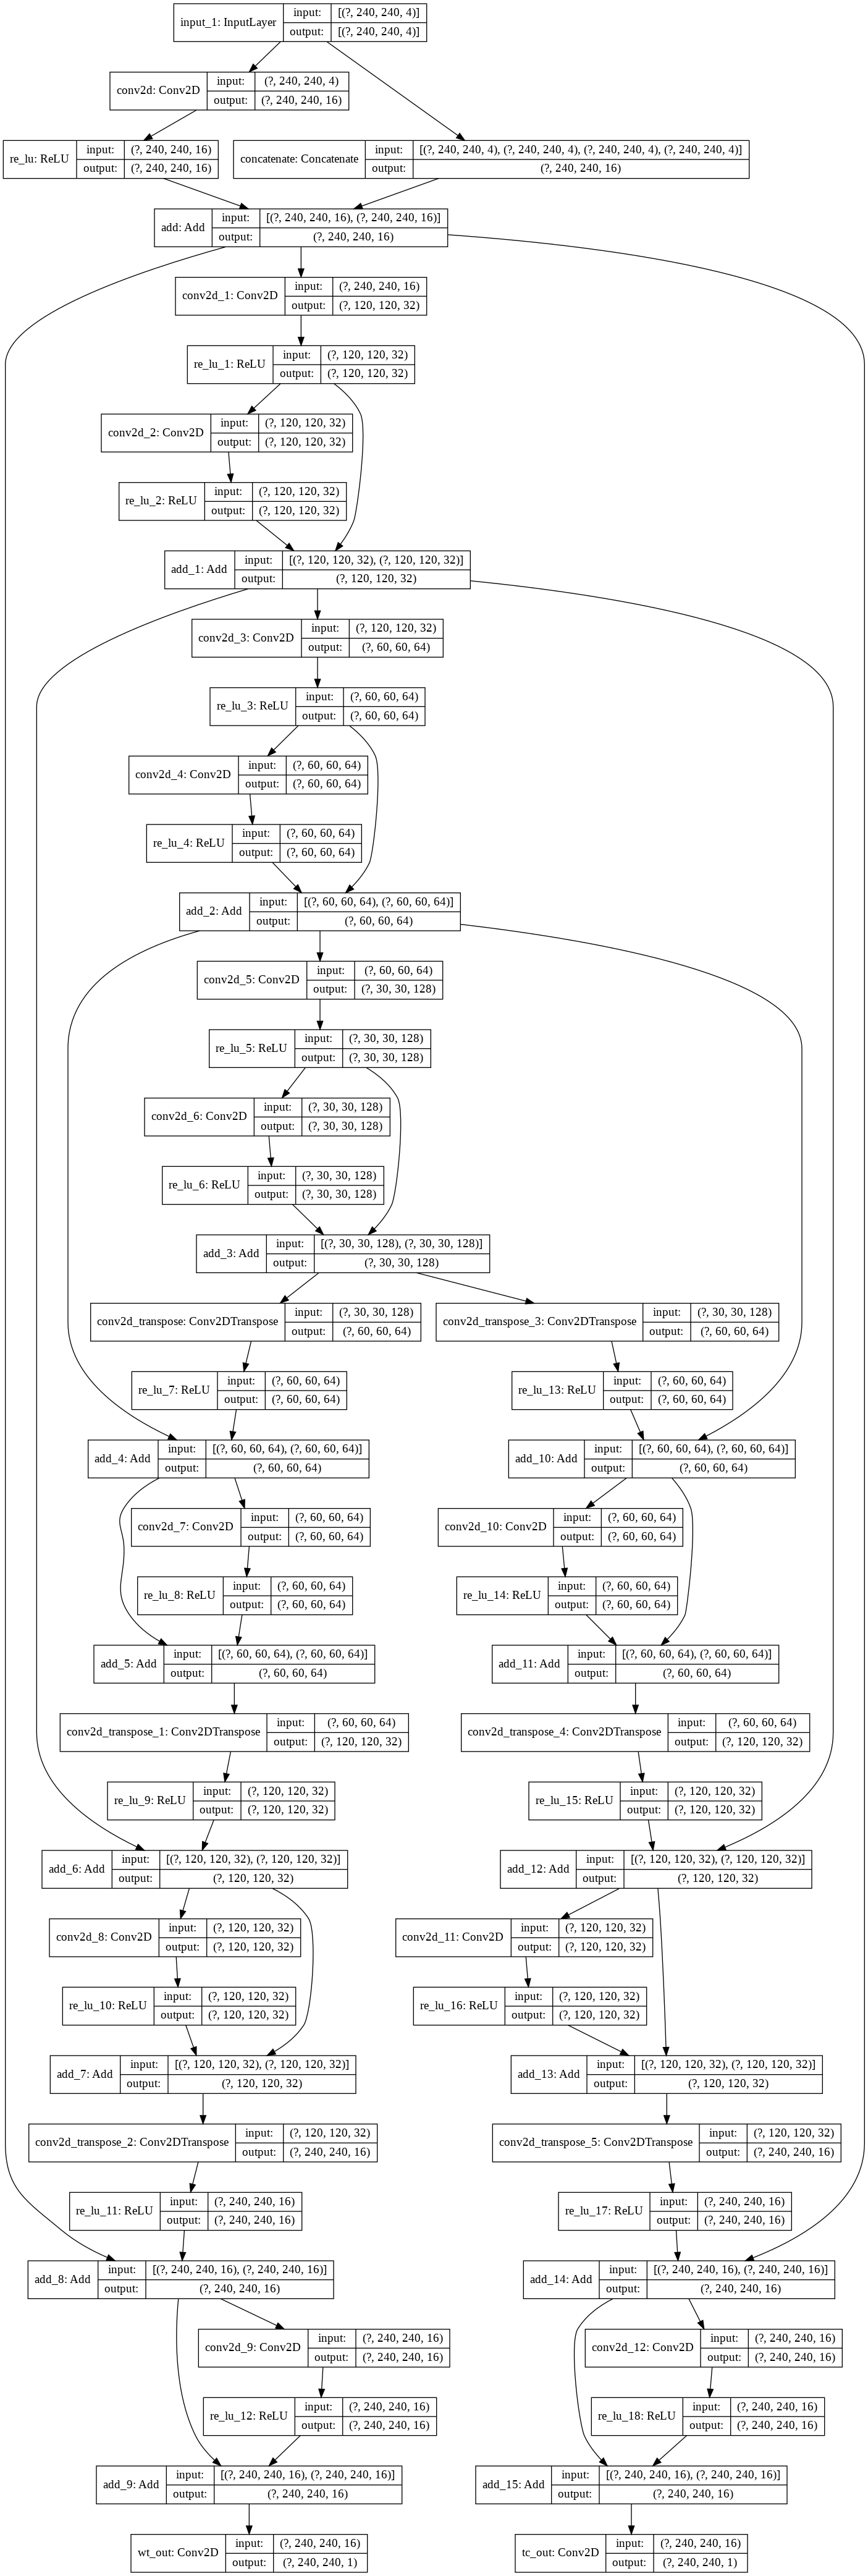

In [17]:
#model = new_model4()
#tf.keras.utils.plot_model(model, to_file='/content/drive/My Drive/MICCAI_BraTS/2020/new_model4_wt+tc.png', show_shapes=True)

In [21]:
model = load_model('/content/drive/My Drive/MICCAI_BraTS/2020/new_model4_wt+tc.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

In [23]:
model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=dice_coef)
#model.compile(optimizer=RMSprop(learning_rate=0.001, momentum=0.0), loss=dice_coef_loss, metrics=dice_coef)

In [22]:
EPOCHS = 1

In [ ]:
loss_tracker = []
for ep in range(EPOCHS):
    loss = 0
    steps = 0
    print(ep+1, '/', EPOCHS)
    for (img, mask) in train_data:

        steps += 1
        print('Step : ', steps)

        mask_wt = tf.logical_or(tf.logical_or(tf.equal(mask, 50), tf.equal(mask, 100)), tf.equal(mask, 200))
        mask_wt = tf.cast(mask_wt, tf.float64)

        mask_tc = tf.logical_or(tf.equal(mask, 50), tf.equal(mask, 200))
        mask_tc = tf.cast(mask_tc, tf.float64)
        
        model.fit(img, [mask_wt, mask_tc])

        if(steps%20==0):
            model.save('/content/drive/My Drive/MICCAI_BraTS/2020/new_model4_wt+tc_ep2.h5')

        #loss += history[0]
        
        #print('Step : ', steps)#, ', Loss : ', history[0], ', Dice Coeff : ', history[1])

        #printm()
    #loss_tracker.append(loss/steps)

1 / 1
Step :  1
1/1 [==============================] - 0s 5ms/step - loss: 0.8321 - wt_out_loss: 0.3909 - tc_out_loss: 0.4412 - wt_out_dice_coef: 0.6091 - tc_out_dice_coef: 0.5588
Step :  2
1/1 [==============================] - 0s 49ms/step - loss: 0.8470 - wt_out_loss: 0.3192 - tc_out_loss: 0.5279 - wt_out_dice_coef: 0.6808 - tc_out_dice_coef: 0.4721
Step :  3
1/1 [==============================] - 0s 2ms/step - loss: 0.5541 - wt_out_loss: 0.1869 - tc_out_loss: 0.3672 - wt_out_dice_coef: 0.8131 - tc_out_dice_coef: 0.6328
Step :  4
1/1 [==============================] - 0s 114ms/step - loss: 0.7701 - wt_out_loss: 0.2814 - tc_out_loss: 0.4886 - wt_out_dice_coef: 0.7186 - tc_out_dice_coef: 0.5114
Step :  5
1/1 [==============================] - 0s 3ms/step - loss: 1.0101 - wt_out_loss: 0.3628 - tc_out_loss: 0.6473 - wt_out_dice_coef: 0.6372 - tc_out_dice_coef: 0.3527
Step :  6
1/1 [==============================] - 0s 112ms/step - loss: 0.5992 - wt_out_loss: 0.1984 - tc_out_loss: 0.4008